In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Flatten, Dense, Conv2D
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random


In [14]:
# Get the current working directory
current_directory = os.getcwd()

# Navigate one folder back
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))

print("Current Directory:", current_directory)
print("Parent Directory:", parent_directory)

Current Directory: d:\Projects\Self Driving Car Simulation\notebooks
Parent Directory: d:\Projects\Self Driving Car Simulation


In [16]:
datadir=os.path.join(parent_directory,'data')
columns=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
print(os.getcwd())
data=pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
data.head()

d:\Projects\Self Driving Car Simulation\notebooks


center  \
0  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
1  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
2  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
3  C:\Users\Amer\Desktop\new_track\IMG\center_201...   
4  C:\Users\Amer\Desktop\new_track\IMG\center_201...   

                                                left  \
0  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
1  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
2  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
3  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   
4  C:\Users\Amer\Desktop\new_track\IMG\left_2018_...   

                                               right  steering  throttle  \
0  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
1  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
2  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
3  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   
4  C:\Users\Amer\Desktop\new_track\IMG\right_2018...       0.0       0.0   

   reverse     speed  
0      0.0  0.649786  
1      0.0  0.627942  
2      0.0  0.622910  
3      0.0  0.619162  
4      0.0  0.615438

In [3]:
def path_leaf(path):
    head, tail =ntpath.split(path)
    return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg       0.0       0.0      0.0  0.649786  
1  right_2018_07_16_17_11_43_670.jpg       0.0       0.0      0.0  0.627942  
2  right_2018_07_16_17_11_43_724.jpg       0.0       0.0      0.0  0.622910  
3  right_2018_07_16_17_11_43_792.jpg       0.0       0.0      0.0  0.619162  
4  right_2018_07_16_17_11_43_860.jpg       0.0       0.0      0.0  0.615438

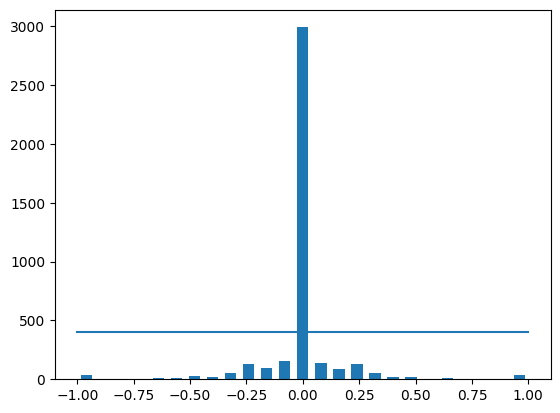

In [4]:
num_bins = 25
samples_per_bin=400
hist, bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+bins[1:])*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [5]:
print('total data:', len(data))
print(data.shape)

total data: 4053
(4053, 7)


In [6]:
remove_list=[]
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    random.shuffle(list_)
    list_=list_[samples_per_bin:]
    remove_list.extend(list_)
    
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))

removed: 2590
remaining 1463


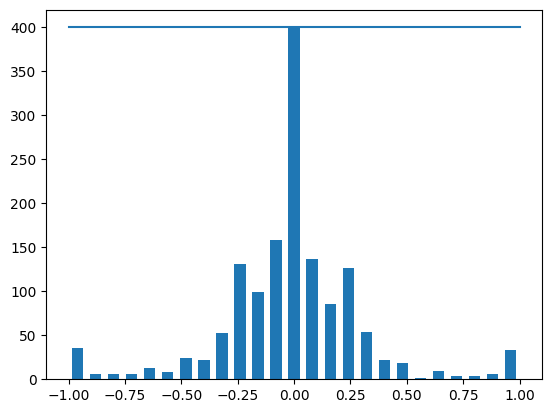

In [7]:
hist, _ = np.histogram(data['steering'],num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [8]:


def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(df)):
        indexed_data = df.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        
        # Center image append
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))

        # Left image append
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)

        # Right image append
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15)

    return image_path, steering


In [9]:
image_paths,steerings=load_img_steering(datadir + '/IMG', data)

C:\Users\asus\AppData\Local\Temp\ipykernel_12400\2827107094.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
C:\Users\asus\AppData\Local\Temp\ipykernel_12400\2827107094.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
C:\Users\asus\AppData\Local\Temp\ipykernel_12400\2827107094.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

In [10]:
image_paths, steerings=np.array(image_paths), np.array(steerings)

In [11]:
image_paths

array(['track/IMG\\center_2018_07_16_17_11_43_670.jpg',
       'track/IMG\\left_2018_07_16_17_11_43_670.jpg',
       'track/IMG\\right_2018_07_16_17_11_43_670.jpg', ...,
       'track/IMG\\center_2018_07_16_17_16_31_474.jpg',
       'track/IMG\\left_2018_07_16_17_16_31_474.jpg',
       'track/IMG\\right_2018_07_16_17_16_31_474.jpg'], dtype='<U44')

In [12]:
steerings

array([ 0.  ,  0.15, -0.15, ...,  0.  ,  0.15, -0.15])

In [13]:
X_train, X_valid, y_train, y_valid=train_test_split(image_paths,steerings,test_size=0.2, random_state=10)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train),len(X_valid)))

Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation Set')

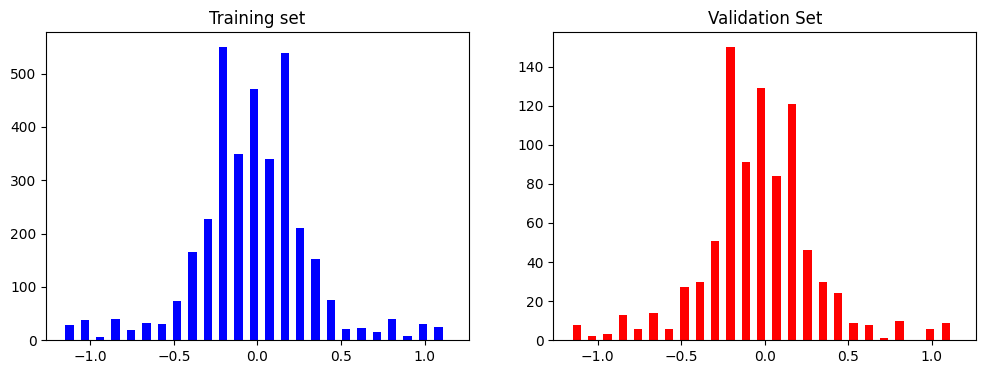

In [14]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid,bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation Set')

### Data Augmentation

Text(0.5, 1.0, 'Zoomed image')

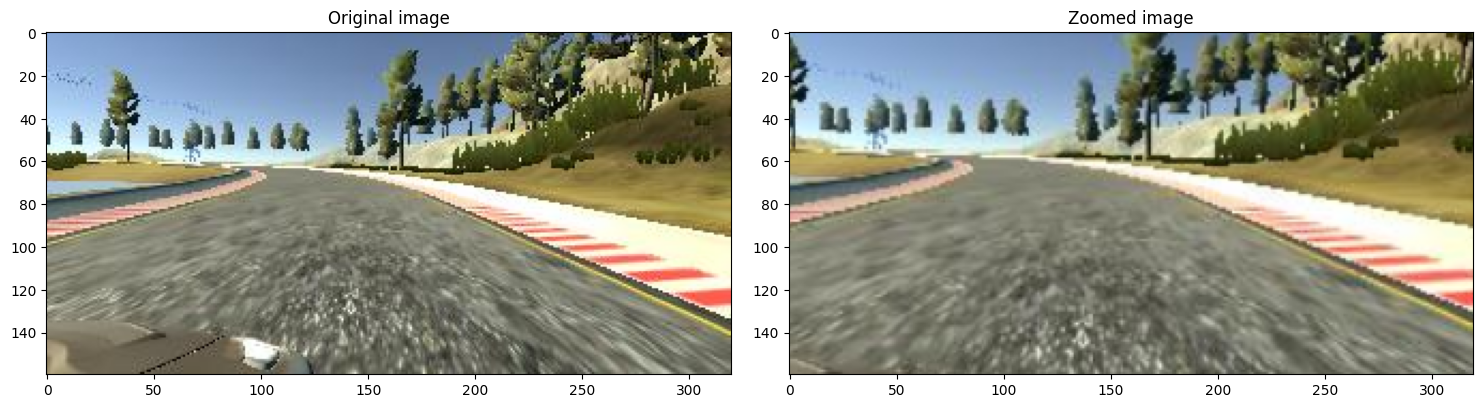

In [15]:
def zoom(image):
    zoom = iaa.Affine(scale=(1,1.3))
    image = zoom.augment_image(image)
    return image

image=image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed image')

Text(0.5, 1.0, 'Panned image')

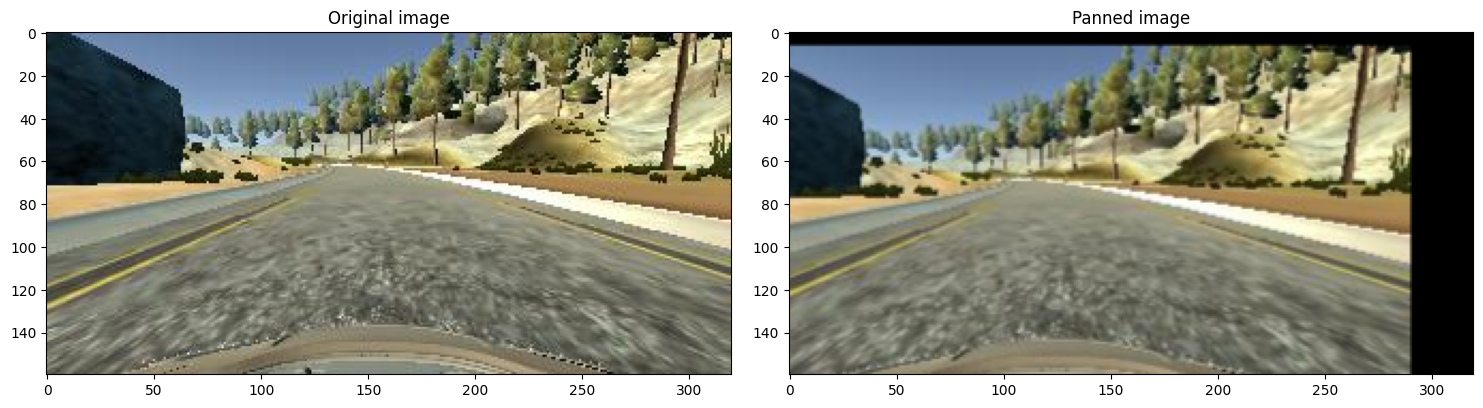

In [16]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x":(-0.1,0.1), "y":(-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

image=image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned image')


Text(0.5, 1.0, 'Brightness Altered image')

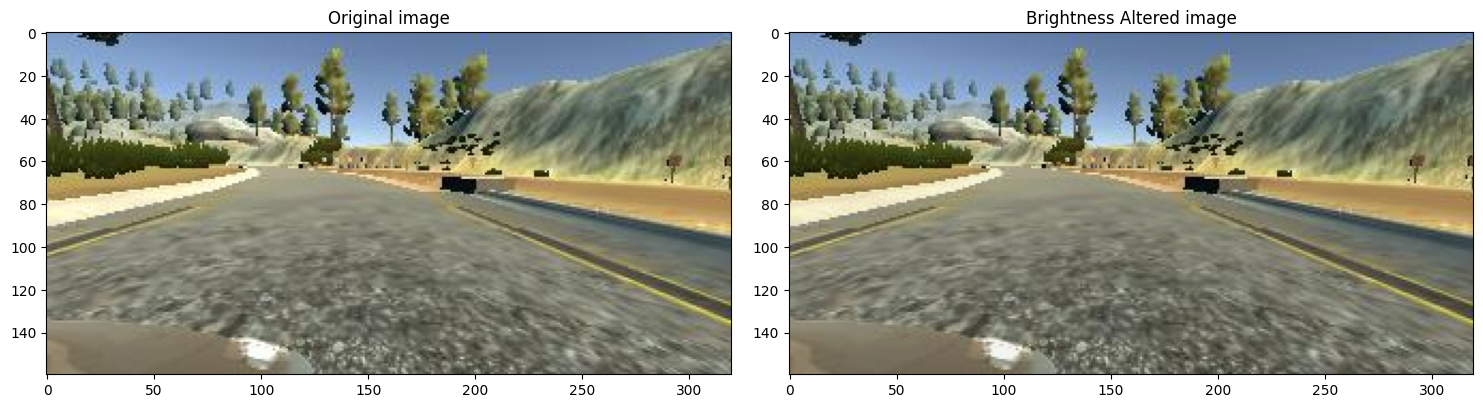

In [17]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2,1.2))
    image = brightness.augment_image(image)
    return image

image=image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered image')


Text(0.5, 1.0, 'Flipped image - Steering Angle:0.0687021')

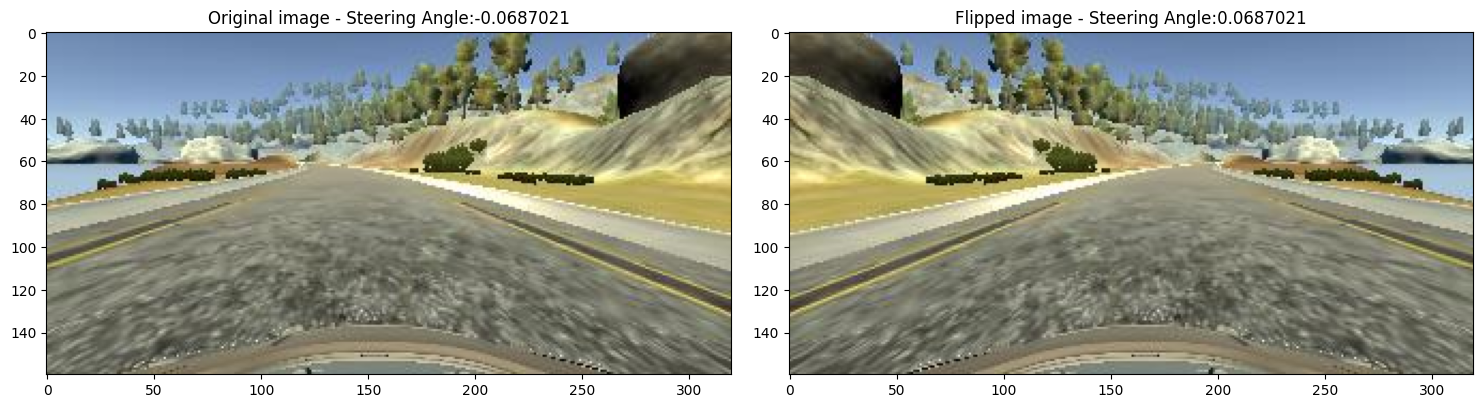

In [18]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped image - ' + 'Steering Angle:' + str(flipped_steering_angle))


In [19]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image,steering_angle

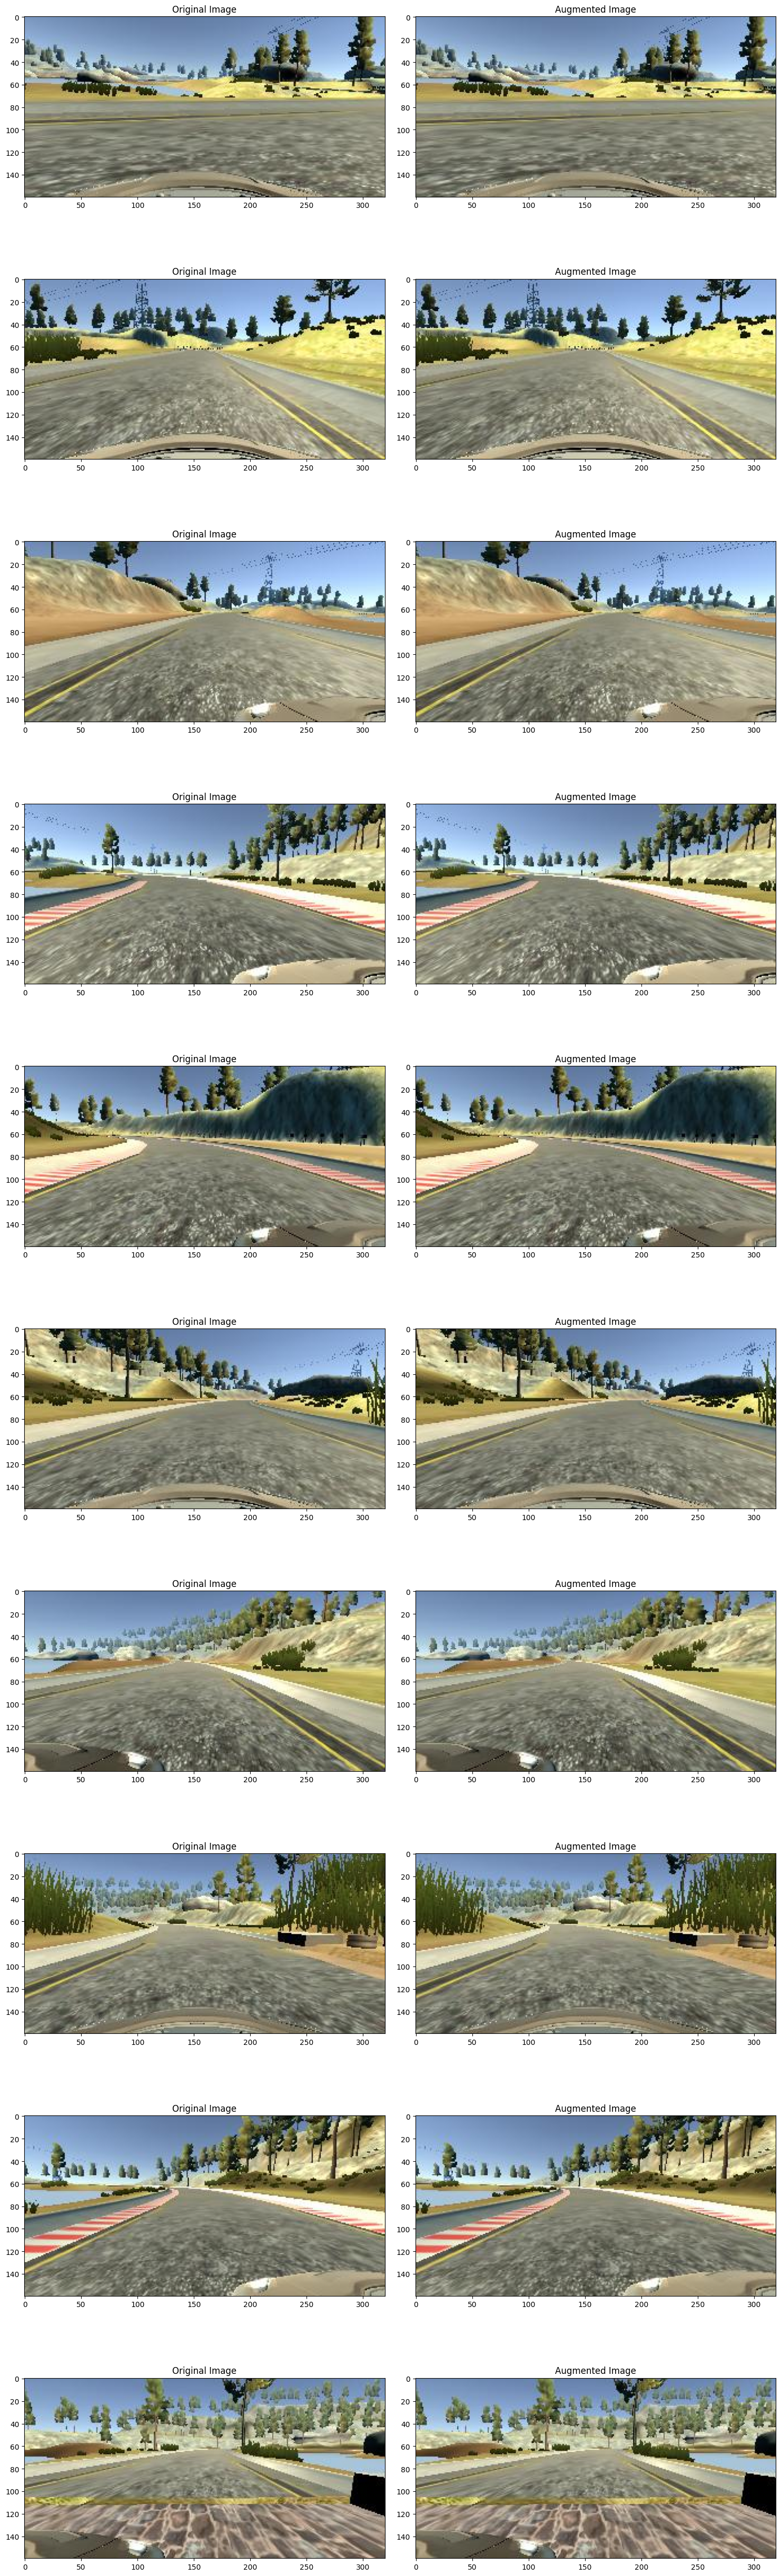

In [20]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()

for i in range(10):
    randnum=random.randint(0, len(image_paths) -1)
    random_image = image_paths[randnum]
    random_steering=steerings[randnum]

    original_image=mpimg.imread(random_image)
    augmented_image,steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(original_image)
    axs[i][1].set_title("Augmented Image")


In [21]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3),0)
    img = cv2.resize(img, (200,66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

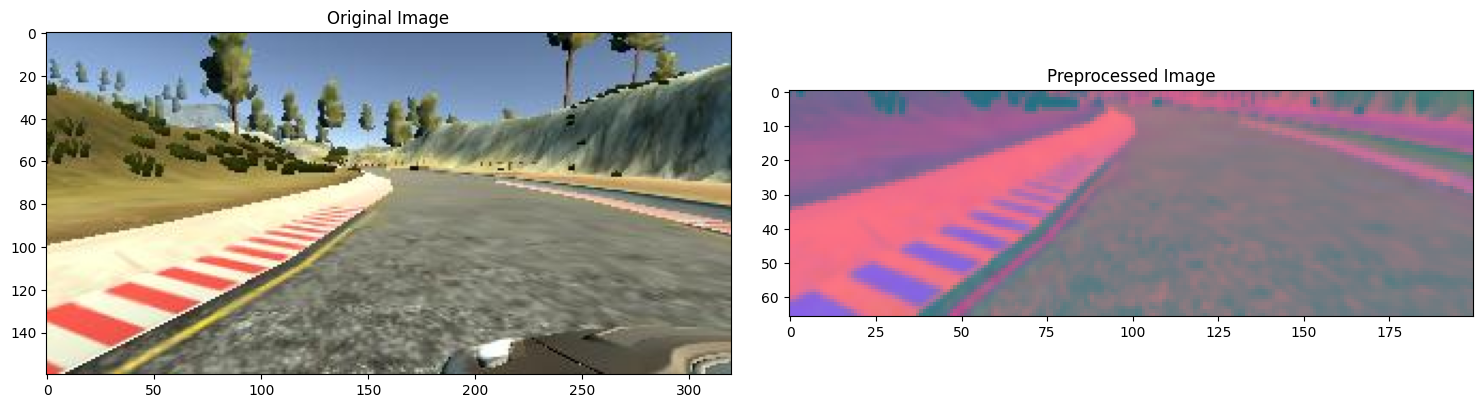

In [22]:
image =image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [23]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index=random.randint(0, len(image_paths)-1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))
        

In [24]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen , y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

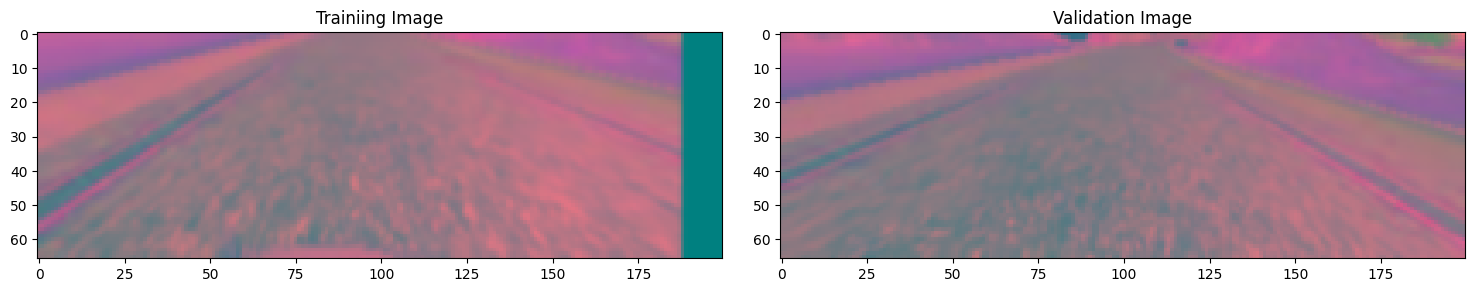

In [25]:
fig, axs = plt.subplots(1,2,figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Trainiing Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [26]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5,5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
    model.add(Conv2D(36, (5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, (5,5),strides=(2,2),activation='elu'))
    model.add(Conv2D(64, (5,5), activation='elu'))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

model=nvidia_model()
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               115300    
                                                                 
 dense_1 (Dense)             (None, 50)                

In [30]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                            steps_per_epoch=300,
                            epochs=10,
                            validation_data=batch_generator(X_valid, y_valid, 100, 0),
                            validation_steps=200,
                            verbose=1,
                            shuffle=1)

C:\Users\asus\AppData\Local\Temp\ipykernel_12400\1355210616.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),


Epoch 1/10
300/300 [==============================] - 486s 2s/step - loss: 0.1088 - val_loss: 0.0732
Epoch 2/10
300/300 [==============================] - 236s 789ms/step - loss: 0.0783 - val_loss: 0.0636
Epoch 3/10
300/300 [==============================] - 140s 468ms/step - loss: 0.0706 - val_loss: 0.0577
Epoch 4/10
300/300 [==============================] - 133s 445ms/step - loss: 0.0628 - val_loss: 0.0505
Epoch 5/10
300/300 [==============================] - 82s 274ms/step - loss: 0.0585 - val_loss: 0.0431
Epoch 6/10
300/300 [==============================] - 141s 470ms/step - loss: 0.0535 - val_loss: 0.0426
Epoch 7/10
300/300 [==============================] - 137s 456ms/step - loss: 0.0496 - val_loss: 0.0367
Epoch 8/10
300/300 [==============================] - 126s 420ms/step - loss: 0.0484 - val_loss: 0.0356
Epoch 9/10
300/300 [==============================] - 130s 434ms/step - loss: 0.0458 - val_loss: 0.0357
Epoch 10/10
300/300 [==============================] - 127s 425ms/st

Text(0.5, 0, 'Epoch')

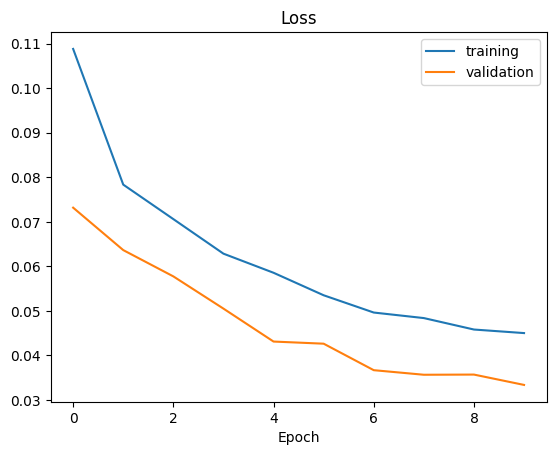

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [32]:
model.save('D:\Projects\Self Driving Car Simulation\model\model.h5')

d:\Projects\Self Driving Car Simulation\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
